# How to build a linear factor model

Algorithmic trading strategies use linear factor models to quantify the relationship between the return of an asset and the sources of risk that represent the main drivers of these returns. Each factor risk carries a premium, and the total asset return can be expected to correspond to a weighted average of these risk premia.

There are several practical applications of factor models across the portfolio management process from construction and asset selection to risk management and performance evaluation. The importance of factor models continues to grow as common risk factors are now tradeable:

- A summary of the returns of many assets by a much smaller number of factors reduces the amount of data required to estimate the covariance matrix when optimizing a portfolio
- An estimate of the exposure of an asset or a portfolio to these factors allows for the management of the resultant risk, for instance by entering suitable hedges when risk factors are themselves traded
- A factor model also permits the assessment of the incremental signal content of new alpha factors
- A factor model can also help assess whether a manager's performance relative to a benchmark is indeed due to skill in selecting assets and timing the market, or if instead, the performance can be explained by portfolio tilts towards known return drivers that can today be replicated as low-cost, passively managed funds without incurring active management fees

## Imports & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
import warnings
from linearmodels.asset_pricing import LinearFactorModel

In [2]:
# due to https://stackoverflow.com/questions/50394873/import-pandas-datareader-gives-importerror-cannot-import-name-is-list-like
# may become obsolete when fixed
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Get Data

Fama and French make updated risk factor and research portfolio data available through their [website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html), and you can use the `pandas_datareader` package to obtain the data.

### Risk Factors

In particular, we will be using the five Fama—French factors that result from sorting stocks first into three size groups and then into two for each of the remaining three firm-specific factors. 

Hence, the factors involve three sets of value-weighted portfolios formed as 3 x 2 sorts on size and book-to-market, size and operating profitability, and size and investment. The risk factor values computed as the average returns of the portfolios (PF) as outlined in the following table:

| Label | Name                          | Description                                                                                                                                                                               |
|-------|-------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| SMB   | Small Minus Big               | Average return on the nine small stock portfolios minus the average return on the nine big stock portfolios                                                                               |
| HML   | High Minus Low                | Average return on the two value portfolios minus the average return on the two growth portfolios                                                                                          |
| RMW   | Robust minus Weak             | Average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios                                           |
| CMA   | Conservative Minus Aggressive | Average return on the two conservative investment portfolios minus the average return on the two aggressive investment portfolios                                                         |
| Rm-Rf | Excess return on the market   | Value-weight return of all firms incorporated in the US and listed on the NYSE, AMEX, or NASDAQ at the beginning of month t with 'good' data for t minus the one-month Treasury bill rate |

The Fama-French 5 factors are based on the 6 value-weight portfolios formed on size and book-to-market, the 6 value-weight portfolios formed on size and operating profitability, and the 6 value-weight portfolios formed on size and investment.

We will use returns at a monthly frequency that we obtain for the period 2010 – 2017 as follows:

In [4]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 6 columns):
Mkt-RF    96 non-null float64
SMB       96 non-null float64
HML       96 non-null float64
RMW       96 non-null float64
CMA       96 non-null float64
RF        96 non-null float64
dtypes: float64(6)
memory usage: 5.2 KB


In [5]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.158437,0.055313,-0.064271,0.143437,0.044792,0.012604
std,3.579997,2.296648,2.197928,1.550179,1.410603,0.022583
min,-7.890000,-4.550000,-4.500000,-4.000000,-3.340000,0.000000
25%,-0.917500,-1.592500,-1.517500,-1.040000,-0.972500,0.000000
50%,1.235000,0.165000,-0.285000,0.120000,-0.030000,0.000000
75%,3.190000,1.502500,1.125000,1.140000,0.932500,0.010000
max,11.350000,6.870000,8.320000,3.510000,3.630000,0.090000


### Portfolios

Fama and French also make available numerous portfolios that we can illustrate the estimation of the factor exposures, as well as the value of the risk premia available in the market for a given time period. We will use a panel of the 17 industry portfolios at a monthly frequency. 

We will subtract the risk-free rate from the returns because the factor model works with excess returns:

In [6]:
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 17 columns):
Food     96 non-null float64
Mines    96 non-null float64
Oil      96 non-null float64
Clths    96 non-null float64
Durbl    96 non-null float64
Chems    96 non-null float64
Cnsum    96 non-null float64
Cnstr    96 non-null float64
Steel    96 non-null float64
FabPr    96 non-null float64
Machn    96 non-null float64
Cars     96 non-null float64
Trans    96 non-null float64
Utils    96 non-null float64
Rtail    96 non-null float64
Finan    96 non-null float64
Other    96 non-null float64
dtypes: float64(17)
memory usage: 13.5 KB


In [7]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.045625,0.203229,0.550833,1.396979,1.154896,1.303438,1.136875,1.731250,0.555625,1.351042,1.227604,1.278854,1.465521,0.891250,1.234375,1.243646,1.282187
std,2.795857,7.902683,5.573364,5.025167,5.137095,5.594231,3.174680,5.246562,7.389824,4.694688,4.811242,5.718887,4.151203,3.237306,3.508655,4.808350,3.711170
min,-5.170000,-24.380000,-11.990000,-10.000000,-13.210000,-17.390000,-7.300000,-13.960000,-20.490000,-11.960000,-9.080000,-11.650000,-8.560000,-6.990000,-9.180000,-11.020000,-7.920000
25%,-0.785000,-5.832500,-3.160000,-1.865000,-2.017500,-1.445000,-0.920000,-2.462500,-4.410000,-1.447500,-2.047500,-1.245000,-0.880000,-0.745000,-0.962500,-1.447500,-1.067500
50%,0.930000,-0.415000,1.050000,1.160000,1.205000,1.435000,1.475000,2.190000,0.660000,1.485000,1.545000,0.645000,1.505000,1.215000,0.880000,1.940000,1.580000
75%,3.187500,5.707500,3.912500,3.857500,4.315000,4.442500,3.317500,5.390000,4.220000,3.875000,4.657500,4.802500,4.227500,2.965000,3.355000,4.052500,3.525000
max,6.670000,21.920000,16.240000,17.200000,16.580000,18.370000,8.290000,15.550000,21.350000,17.660000,14.650000,20.860000,13.160000,7.900000,12.360000,13.430000,10.800000


### Equity Data

In [8]:
with pd.HDFStore('../data/assets.h5') as store:
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']
    equities = store['/us_equities/stocks'].drop_duplicates()

In [9]:
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

In [10]:
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1893 entries, A to ZUMZ
dtypes: float64(1893)
memory usage: 1.4 MB


### Align data

In [11]:
ff_factor_data = ff_factor_data.loc[returns.index]
ff_portfolio_data = ff_portfolio_data.loc[returns.index]

In [12]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206000,0.052737,-0.068211,0.159368,0.040737,0.012737
std,3.568367,2.308693,2.209247,1.550482,1.417523,0.022665
min,-7.890000,-4.550000,-4.500000,-4.000000,-3.340000,0.000000
25%,-0.565000,-1.605000,-1.535000,-0.920000,-0.975000,0.000000
50%,1.290000,0.130000,-0.290000,0.140000,-0.030000,0.000000
75%,3.260000,1.545000,1.130000,1.140000,0.935000,0.010000
max,11.350000,6.870000,8.320000,3.510000,3.630000,0.090000


### Compute excess Returns

In [13]:
excess_returns = returns.sub(ff_factor_data.RF, axis=0)
excess_returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1893 entries, A to ZUMZ
dtypes: float64(1893)
memory usage: 1.4 MB


In [14]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

## Fama-Macbeth Regression

Given data on risk factors and portfolio returns, it is useful to estimate the portfolio's exposure, that is, how much the risk factors drive portfolio returns, as well as how much the exposure to a given factor is worth, that is, the what market's risk factor premium is. The risk premium then permits to estimate the return for any portfolio provided the factor exposure is known or can be assumed.

In [15]:
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 17 columns):
Food     95 non-null float64
Mines    95 non-null float64
Oil      95 non-null float64
Clths    95 non-null float64
Durbl    95 non-null float64
Chems    95 non-null float64
Cnsum    95 non-null float64
Cnstr    95 non-null float64
Steel    95 non-null float64
FabPr    95 non-null float64
Machn    95 non-null float64
Cars     95 non-null float64
Trans    95 non-null float64
Utils    95 non-null float64
Rtail    95 non-null float64
Finan    95 non-null float64
Other    95 non-null float64
dtypes: float64(17)
memory usage: 13.4 KB


In [16]:
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 6 columns):
Mkt-RF    95 non-null float64
SMB       95 non-null float64
HML       95 non-null float64
RMW       95 non-null float64
CMA       95 non-null float64
RF        95 non-null float64
dtypes: float64(6)
memory usage: 5.2 KB


To address the inference problem caused by the correlation of the residuals, Fama and MacBeth proposed a two-step methodology for a cross-sectional regression of returns on factors. The two-stage Fama—Macbeth regression is designed to estimate the premium rewarded for the exposure to a particular risk factor by the market. The two stages consist of:

- First stage: N time-series regression, one for each asset or portfolio, of its excess returns on the factors to estimate the factor loadings.

- Second stage: T cross-sectional regression, one for each time period, to estimate the risk premium.

See corresponding section in Chapter 7 of [Machine Learning for Trading](https://www.amazon.com/Hands-Machine-Learning-Algorithmic-Trading-ebook/dp/B07JLFH7C5/ref=sr_1_2?ie=UTF8&qid=1548455634&sr=8-2&keywords=machine+learning+algorithmic+trading) for details.

Now we can compute the factor risk premia as the time average and get t-statistic to assess their individual significance, using the assumption that the risk premia estimates are independent over time.

If we had a very large and representative data sample on traded risk factors we could use the sample mean as a risk premium estimate. However, we typically do not have a sufficiently long history to and the margin of error around the sample mean could be quite large. 

The Fama—Macbeth methodology leverages the covariance of the factors with other assets to determine the factor premia. The second moment of asset returns is easier to estimate than the first moment, and obtaining more granular data improves estimation considerably, which is not true of mean estimation.

### Step 1: Factor Exposures

We can implement the first stage to obtain the 17 factor loading estimates as follows:

In [17]:
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))

In [18]:
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=ff_portfolio_data.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 6 columns):
Mkt-RF    17 non-null float64
SMB       17 non-null float64
HML       17 non-null float64
RMW       17 non-null float64
CMA       17 non-null float64
RF        17 non-null float64
dtypes: float64(6)
memory usage: 1.6+ KB


### Step 2: Risk Premia

For the second stage, we run 96 regressions of the period returns for the cross section of portfolios on the factor loadings

In [19]:
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)

In [20]:
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 6 columns):
Mkt-RF    95 non-null float64
SMB       95 non-null float64
HML       95 non-null float64
RMW       95 non-null float64
CMA       95 non-null float64
RF        95 non-null float64
dtypes: float64(6)
memory usage: 7.7 KB


In [21]:
lambdas.mean()

Mkt-RF    1.243145
SMB      -0.000426
HML      -0.687413
RMW      -0.239481
CMA      -0.312648
RF       -0.013285
dtype: float64

In [22]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.346728
SMB      -0.000109
HML      -0.197172
RMW      -0.078520
CMA      -0.107598
RF       -0.159656
dtype: float64

#### Results

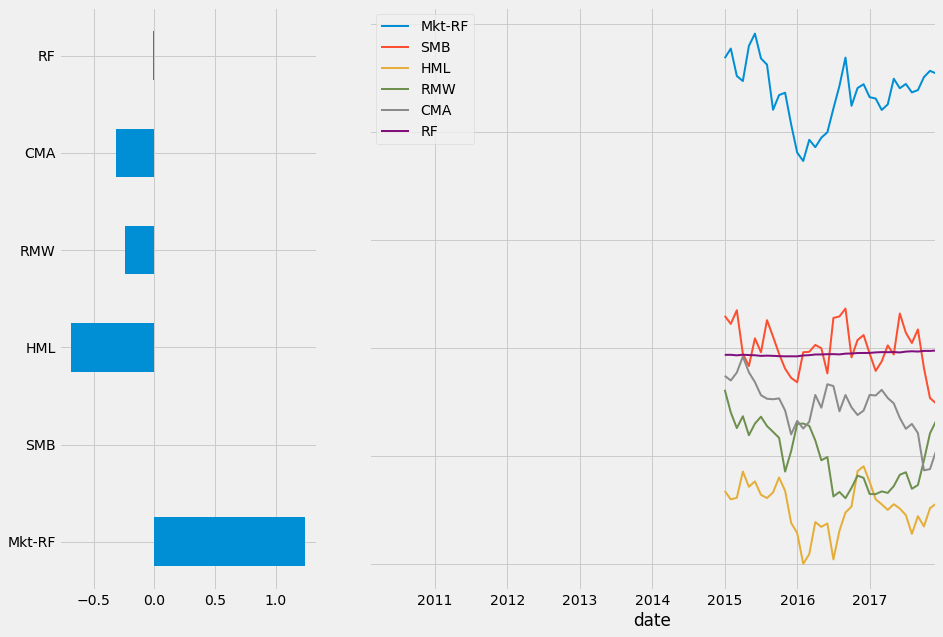

In [23]:
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().plot.barh(ax=ax1)
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), sharey=True, ax=ax2);

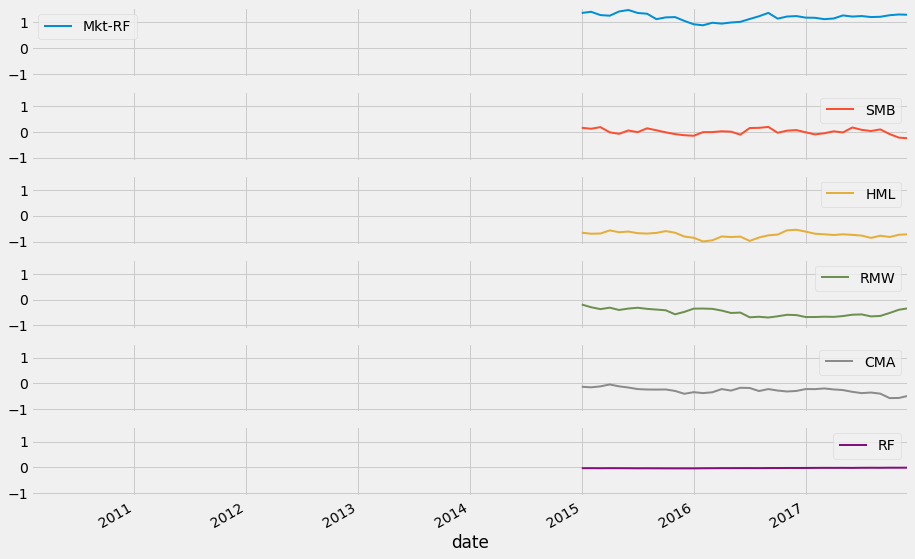

In [24]:
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), subplots=True,sharey=True);

## Fama-Macbeth with the LinearModels library

The linear_models library extends statsmodels with various models for panel data and also implements the two-stage Fama—MacBeth procedure:

In [25]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6944
No. Factors:                          6   J-statistic:                    19.315
No. Observations:                    95   P-value                         0.0557
Date:                  Thu, Jun 27 2019   Distribution:                 chi2(11)
Time:                          18:34:15                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2431     0.3929     3.1638     0.0016      0.4730      2.0133
SMB           -0.0004     0.7032    

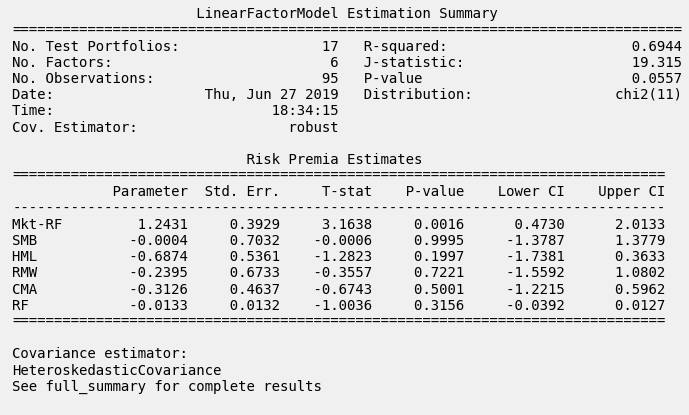

In [26]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('factor_model.png', bbox_inches='tight', dpi=300);

This provides us with the same result:

In [27]:
lambdas.mean()

Mkt-RF    1.243145
SMB      -0.000426
HML      -0.687413
RMW      -0.239481
CMA      -0.312648
RF       -0.013285
dtype: float64